# ChatGPT sentiment analysis using backpropagation

## Topic

The dataset for this notebook was obtained by gathering and labeling tweets about ChatGPt that has been a major providor of AI based communication chatbots. The tweets can be good, bad or neutral and my goal is to build a neural network that backpropagates on its error and learns the difference between the three kind of sentences.


## Objective

- Build a neural network that can classify a sentence as positive, negative or neutral

## Summary

- Importing libraries
- The dataset
- Converting characters to lower case
- Removing punctuation
- Removing digits 
- Tokenizing
- Removing stopwrods
- Removing frequent words
- Stemming
- Bag of words
- Creating train/test loaders
- Building the classifier
- Training and inference
- Trying out the model
- Conclusion

### Importing libraries

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from scipy.sparse import coo_matrix
import string
from nltk import FreqDist
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### The Dataset

In [233]:
data = pd.read_csv(r'C:\Users\imane\Downloads\archive (9)\file.csv', sep =",")
data.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  219294 non-null  int64 
 1   tweets      219294 non-null  object
 2   labels      219294 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


The dataset contains around 230 000 instances labeled as good, bad or neutral. Senn as I will be using bag of words later on, I decided to only keep a portion of the data  for faster processing.

In [235]:
data = data.iloc[:10000]

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   tweets      10000 non-null  object
 2   labels      10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [237]:
target = data["labels"]

In [238]:
df = data.drop(columns=["labels", "Unnamed: 0"], axis =1)

In [239]:
target.head()

0    neutral
1       good
2    neutral
3       good
4        bad
Name: labels, dtype: object

Here I isolated the labels and kept only the training samples in the dataset.

### Converting characters to lower case

In [240]:
df["tweets"] = df["tweets"].str.lower()

In [241]:
df.head()

,tweets
0,chatgpt: optimizing language models for dialog...
1,"try talking with chatgpt, our new ai system wh..."
2,chatgpt: optimizing language models for dialog...
3,"thrilled to share that chatgpt, our new model ..."
4,"as of 2 minutes ago, @openai released their ne..."


### Removing Punctuation

In [242]:
def remove_punct(text):
    text = text.translate(str.maketrans(" "," ", string.punctuation ))
    return text

In [243]:
df["tweets"] = df["tweets"].apply(remove_punct)
df.head()

,tweets
0,chatgpt optimizing language models for dialogu...
1,try talking with chatgpt our new ai system whi...
2,chatgpt optimizing language models for dialogu...
3,thrilled to share that chatgpt our new model o...
4,as of 2 minutes ago openai released their new ...


### Removing digits

In [244]:
def remove_digits(text):
    exclude = text
    return "".join(token for token in text if not token.isdigit())

In [245]:
df["tweets"] = df["tweets"].apply(remove_digits)
df.head()

,tweets
0,chatgpt optimizing language models for dialogu...
1,try talking with chatgpt our new ai system whi...
2,chatgpt optimizing language models for dialogu...
3,thrilled to share that chatgpt our new model o...
4,as of minutes ago openai released their new c...


### Tokenizing the sentences

In [246]:
df["tweets"] = df["tweets"].apply(lambda X: word_tokenize(X))
df.head()

,tweets
0,"[chatgpt, optimizing, language, models, for, d..."
1,"[try, talking, with, chatgpt, our, new, ai, sy..."
2,"[chatgpt, optimizing, language, models, for, d..."
3,"[thrilled, to, share, that, chatgpt, our, new,..."
4,"[as, of, minutes, ago, openai, released, their..."


### Removing Stopwords

In [247]:
stopwords = stopwords.words("english")

In [248]:
def remove_stopwords(text):
    results = []
    for token in text:
        if token not in stopwords:
            results.append(token)
    return results

In [249]:
df["tweets"] = df["tweets"].apply(remove_stopwords)

In [250]:
df.head()

,tweets
0,"[chatgpt, optimizing, language, models, dialog..."
1,"[try, talking, chatgpt, new, ai, system, optim..."
2,"[chatgpt, optimizing, language, models, dialog..."
3,"[thrilled, share, chatgpt, new, model, optimiz..."
4,"[minutes, ago, openai, released, new, chatgpt,..."


### Removing frequent words

In [251]:
def frequent_words(df):
    list = []
    for text in df.values:
        list += text[0]
    frequent = FreqDist(list)
    return frequent.most_common(30)


In [252]:
frequent_words(df)

[('chatgpt', 9444),
 ('openai', 1770),
 ('’', 1278),
 ('ai', 1247),
 ('asked', 787),
 ('like', 714),
 ('new', 712),
 ('write', 710),
 ('code', 559),
 ('good', 536),
 ('google', 510),
 ('gpt', 448),
 ('using', 397),
 ('questions', 373),
 ('im', 350),
 ('get', 346),
 ('openais', 344),
 ('answer', 330),
 ('language', 317),
 ('time', 311),
 ('one', 311),
 ('people', 311),
 ('really', 307),
 ('going', 299),
 ('would', 296),
 ('chatbot', 289),
 ('know', 288),
 ('see', 286),
 ('even', 283),
 ('think', 280)]

In [254]:
frequent = frequent_words(df)
lst = []
for a, b in frequent:
    lst.append(a)

In [255]:
def remove_freq(text):
    result = []
    for item in text:
        if item not in lst:
            result.append(item)
    return result

In [256]:
df["tweets"] = df["tweets"].apply(remove_freq)

### Stemming

In [257]:
def stem(text):
    stemmer = PorterStemmer()
    results = []
    for word in text:
        results.append(stemmer.stem(word))
    return results

In [258]:
df["tweets"] = df["tweets"].apply(stem)
df.head(5)

,tweets
0,"[optim, model, dialogu, httpstcokrkrygyyn]"
1,"[tri, talk, system, optim, dialogu, feedback, ..."
2,"[optim, model, dialogu, httpstcoglebmoknw, mac..."
3,"[thrill, share, model, optim, dialog, public, ..."
4,"[minut, ago, releas, nnand, use, right, 👇, htt..."


### Bag of words

In [259]:
vec = CountVectorizer()

In [260]:
text = df["tweets"].map(' '.join)
vec.fit(text)

CountVectorizer()

In [261]:
converted = vec.transform(text)

In [262]:
converted.shape

(10000, 21817)

After applying the bag of words vectorizer we obtained vectors od shape 21 817. Which means the network must have as many nodes in the input layer.

### Splitting the training and testing data

In [263]:
X_train, X_test, y_train ,y_test = train_test_split(converted, target, random_state = 42, test_size = 0.25, shuffle = True)

In [264]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Encoding the target 

In [265]:
encoder =  LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### Constructing sparse matrices for the training and testing sets

In [266]:
coo_t = coo_matrix(X_train, dtype= "float32")
values = coo_t.data
indices = np.vstack((coo_t.row, coo_t.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_t.shape

X = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [267]:
coo_v = coo_matrix(X_test, dtype= "float32")

values = coo_v.data
indices = np.vstack((coo_v.row, coo_v.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_v.shape

Y = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

### Creating the train/test loaders

In [268]:
class Train_loader(Dataset):
    def __init__(self):
        self.X = X
        self.Y = torch.tensor(y_train, dtype = torch.long)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [269]:
class Test_loader(Dataset):
    def __init__(self):
        self.X = Y
        self.Y = torch.tensor(y_test, dtype = torch.long)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [270]:
train_data = Train_loader()
test_data = Test_loader()

In [271]:
train_loader = DataLoader(dataset = train_data, batch_size= 128)
test_loader = DataLoader(dataset = test_data, batch_size= 128)

In here I created train and test loaders that will take data in batches for the network to process, I chose a big batch size because I discovered that for this dataset the higher the batch size the higher is the accuracy.

### Building the classifier

In [272]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21817, 190)
        self.fc2 = nn.Linear(190, 3)
        
        self.dropout = nn.Dropout(p= 0.7)
        self.batchn1 = nn.BatchNorm1d(190)

    
    def forward(self, x):
        
        
        x = self.dropout(F.leaky_relu(self.batchn1(self.fc1(x))))
        
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

In [273]:
classifier = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr= 0.0005)

### training and Inference

In [274]:
epochs = 30
train_loss, test_loss = [], []
train_accuracy, test_accuracy = [],[]
for epoch in range(epochs):
    t_loss = 0
    train_acc = 0
    for sentence, label in train_loader:
        optimizer.zero_grad()
        logits = classifier(sentence)
        loss = criterion(logits, label)
        t_loss += loss.item()
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == label.view(*top_class.shape)
        train_acc += equals.sum().item()
        loss.backward()
        optimizer.step()
    
    else:
        accuracy = 0
        v_loss = 0
        with torch.no_grad():
            classifier.eval()
            for sentence, label in test_loader:
                logits = classifier(sentence)
                loss = criterion(logits, label)
                v_loss += loss.item()
                ps = torch.exp(logits)
                top_k, top_class = ps.topk(1, dim=1)
                equals = top_class == label.view(*top_class.shape)
                accuracy += equals.sum().item()
        
        train_loss.append(t_loss/len(train_loader.dataset))
        test_loss.append(v_loss/len(test_loader.dataset))
        train_accuracy.append(train_acc /len(train_loader))
        test_accuracy.append(accuracy/len(test_loader))
        classifier.train()
        
        print("Epoch", epoch+1, "Accuracy", accuracy/len(test_loader))

Epoch 1 Accuracy 82.8
Epoch 2 Accuracy 87.25
Epoch 3 Accuracy 88.2
Epoch 4 Accuracy 88.0
Epoch 5 Accuracy 88.45
Epoch 6 Accuracy 88.2
Epoch 7 Accuracy 88.0
Epoch 8 Accuracy 87.8
Epoch 9 Accuracy 87.4
Epoch 10 Accuracy 87.15
Epoch 11 Accuracy 87.2
Epoch 12 Accuracy 87.85
Epoch 13 Accuracy 86.8
Epoch 14 Accuracy 87.05
Epoch 15 Accuracy 87.25
Epoch 16 Accuracy 87.0
Epoch 17 Accuracy 86.7
Epoch 18 Accuracy 86.5
Epoch 19 Accuracy 86.85
Epoch 20 Accuracy 87.05
Epoch 21 Accuracy 86.8
Epoch 22 Accuracy 86.65
Epoch 23 Accuracy 86.25
Epoch 24 Accuracy 86.6
Epoch 25 Accuracy 87.0
Epoch 26 Accuracy 86.55
Epoch 27 Accuracy 86.5
Epoch 28 Accuracy 86.7
Epoch 29 Accuracy 86.55
Epoch 30 Accuracy 86.4


This is the part where I build the network. I created a simple network with only two layers (input, output), I also used a dropout by 70% and batch normalization. I used the negative log likelihood loss as my loss criterion and Adam optimizer for the gradient optimization part with a learning rate of 0.0005. I set up the epochs for 30, looped through every instance in the batch, passed the instance through the classifier, calculated the error and backpropagated it to set up the new gradients. And after each loop of training I made predictions and calculated the accuracy. The accuracy I got is not below 85% which means that my classifier is able to differenciate between the three classes.

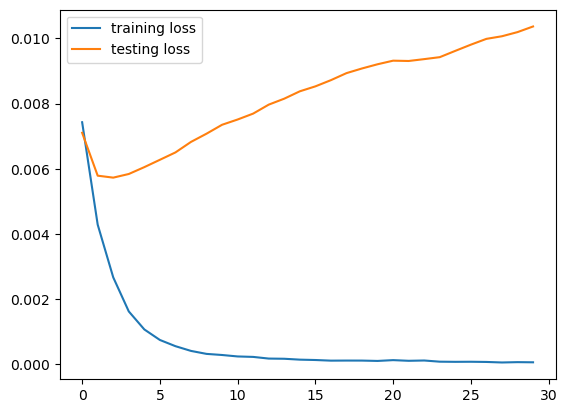

In [275]:
plt.plot(train_loss, label="training loss")
plt.plot(test_loss, label="testing loss")
plt.legend()

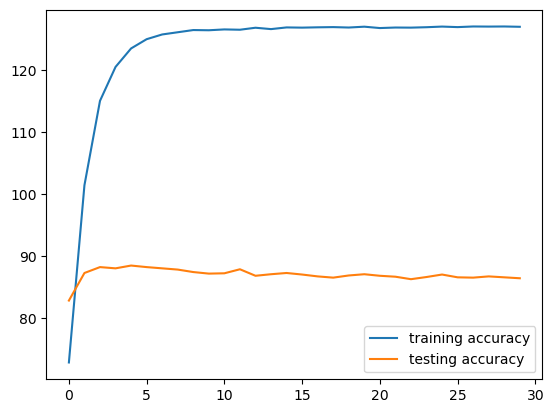

In [276]:
plt.plot(train_accuracy, label="training accuracy")
plt.plot(test_accuracy, label="testing accuracy")
plt.legend()

The accuracy and loss plots on the training VS testing set shows a much higher accuracy on training then testing and much lower error on training then testing. I can say that my model overfits that's why I used dropout and batch normalization earlier. But its performence on the testing set is good enough for it to be used

### Trying out the model

In [280]:
t = pd.DataFrame(target)

In [282]:
t["encoding"] = encoder.transform(t["labels"].values)
t = t.drop_duplicates('labels')
t

,labels,encoding
0,neutral,2
1,good,1
4,bad,0


In [330]:
classifier.eval()
sentence = data["tweets"][4]
print("sentence: ",sentence)
sentence, label = next(iter(train_loader))
s = sentence[4]
s = s.view(1, s.shape[0])
with torch.no_grad():
    output = classifier(s)
ps = torch.exp(output)
print("Actual label", label[4])
print("Model's probabilities: ", ps)

sentence:  As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1
Actual label tensor(1)
Model's probabilities:  tensor([[8.3546e-07, 9.9999e-01, 1.2251e-05]])


In [332]:
sentence = data["tweets"][18]
print("sentence: ",sentence)
sentence, label = next(iter(train_loader))
s = sentence[18]
s = s.view(1, s.shape[0])
with torch.no_grad():
    output = classifier(s)
ps = torch.exp(output)
print("Actual label", label[18])
print("Model's probabilities: ", ps)

sentence:  OpenAI ChatGPT: Optimizing Language Models for Dialogue https://t.co/BRJfW34pdY \n2
Actual label tensor(0)
Model's probabilities:  tensor([[9.9850e-01, 1.3462e-03, 1.5146e-04]])


In [336]:
sentence = data["tweets"][22]
print("sentence: ",sentence)
sentence, label = next(iter(train_loader))
s = sentence[22]
s = s.view(1, s.shape[0])
with torch.no_grad():
    output = classifier(s)
ps = torch.exp(output)
print("Actual label", label[22])
print("Model's probabilities: ", ps)

sentence:  OpenAI ChatGPT: Optimizing Language Models for Dialogue https://t.co/jRycgdz0gI
Actual label tensor(2)
Model's probabilities:  tensor([[1.5141e-05, 2.8746e-05, 9.9996e-01]])


First of all I printed out the labels and their encoding (0 for bad, 1 for good, and 2 for neutral). I then printed sentences and their actual label and passed them through my classifier where I got 3 probabilities each representing a class. Comparing the highest probabilities and the actual labels, I can see that the model did great on the three instances.

## Conclusion

In this notebook I had the chance to experiment with a simple neural network to classify sentiment for ChatGPT. I used backpropagation to train my network and update its gradients at each iteration. the result was a classifier that overfits but can accurately predict the class up to 85%. 